In [18]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.data import shepp_logan_phantom
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim

# Step 1: Import and preprocess MNIST data
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = torch.utils.data.DataLoader(mnist, batch_size=64, shuffle=True)

"""
example_img, _ = mnist[2]
example_img = example_img.numpy().squeeze()
theta = np.linspace(0., 180., max(example_img.shape), endpoint=False)
sinogram = radon(example_img, theta=theta)
"""

phantom = shepp_logan_phantom()
phantom = phantom[::2, ::2]  # Downsample for faster computation
theta = np.linspace(0., 180., max(phantom.shape), endpoint=False)
sinogram = radon(phantom, theta=theta)

In [3]:
# Step 2: Define the denoising autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize and train the denoising autoencoder
autoencoder = DenoisingAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
for epoch in range(3):  # Keep it small for demo purposes
    for data in mnist_loader:
        img, _ = data
        noisy_img = img + 0.5 * torch.randn_like(img)
        noisy_img = torch.clamp(noisy_img, 0., 1.)
        optimizer.zero_grad()
        output = autoencoder(noisy_img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()


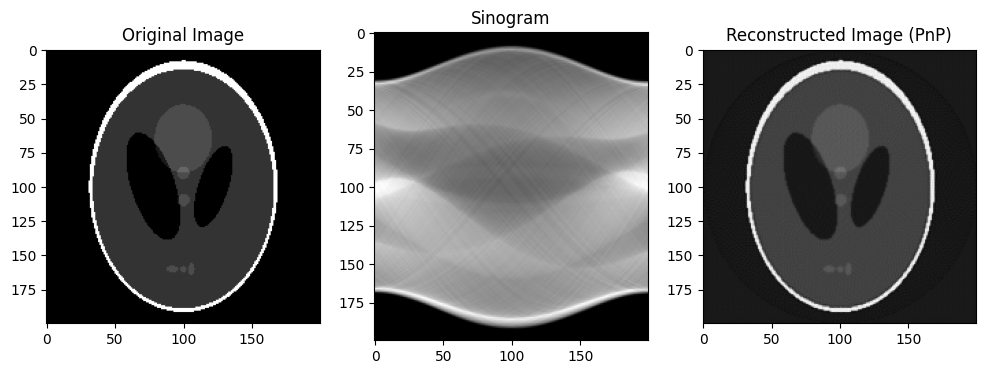

In [22]:

# Step 3: PnP algorithm
def pnp_reconstruction(sinogram, denoiser, num_iter=10):
    # Initial reconstruction using filtered back projection
    reconstruction_fbp = iradon(sinogram, theta=theta, circle=True)
    x = torch.tensor(reconstruction_fbp).float().unsqueeze(0).unsqueeze(0)
    
    for _ in range(num_iter):
        x = denoiser(x)
        x_np = x.detach().numpy().squeeze()
        sinogram_current = radon(x_np, theta=theta)
        residual = sinogram - sinogram_current
        update = iradon(residual, theta=theta, circle=True)
        x += torch.tensor(update).float().unsqueeze(0).unsqueeze(0)
        
    return x.detach().numpy().squeeze()

# Reconstruct the image using PnP

reconstructed_img = pnp_reconstruction(sinogram, autoencoder, num_iter=30)

# Display the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(phantom, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Sinogram')
plt.imshow(sinogram, cmap='gray', aspect='auto')
plt.subplot(1, 3, 3)
plt.title('Reconstructed Image (PnP)')
plt.imshow(reconstructed_img, cmap='gray')
plt.show()